https://www.kaggle.com/wanghaohan/confused-eeg

Task:
- Classification of the video being confusing or not confusing
- Input data (time X subjects)
- Graphs: bi-direction time-graph + subjects graph
- Samples: video recorded at different time-points for augmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler

np.random.seed(0)

# 1. Read Data

In [2]:
df_eeg = pd.read_pickle('student_eeg/df_eeg.pkl')
df_demo = pd.read_pickle('student_eeg/df_demo.pkl')
features = pd.read_pickle('student_eeg/features.pkl')

# 2. Generate Graphs

## 2.1. Subjects Graph

In [3]:
X = df_demo[[' age', ' gender']].copy()
X[' gender'] = X[' gender'].replace(['M', 'F'], [0, 1])

In [4]:
alpha = 0.2
A_s = np.exp(-alpha*pairwise_distances(X))
A_s[range(A_s.shape[0]), range(A_s.shape[0])] = 0
A_s = pd.DataFrame(A_s, index=df_demo['subject ID'], columns=df_demo['subject ID'])

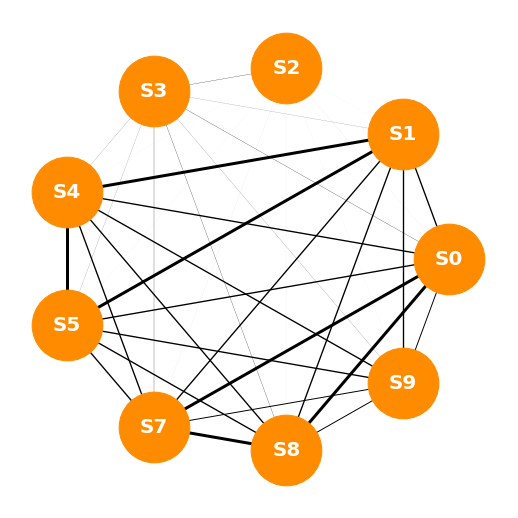

In [5]:
# PLOTTING FUNCITONS
import networkx as nx

cols = [f'S{c}' for c in A_s.columns]
A_s.columns, A_s.index = cols, cols

G = nx.from_pandas_adjacency(A_s, create_using=nx.Graph)
edges = G.edges()
weights = [G[u][v]['weight']**4 *3 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=True, 
                 node_size=5000, node_color='DARKORANGE', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=30)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])

plt.savefig('A_s.png')

## 2.2. Bi-Directional Time Graph

In [6]:
# Adjacency matrix as a constant variable (N x N)
lbw = 10
damping_constant = 0.9
A_t = np.zeros((lbw, lbw))
for row_idx in range(A_t.shape[0]):
    for col_idx in range(A_t.shape[1]):
        if col_idx > row_idx:
            A_t[row_idx, col_idx] = damping_constant**(col_idx-row_idx)
        
A_t = A_t + A_t.T
A_t = pd.DataFrame(A_t)

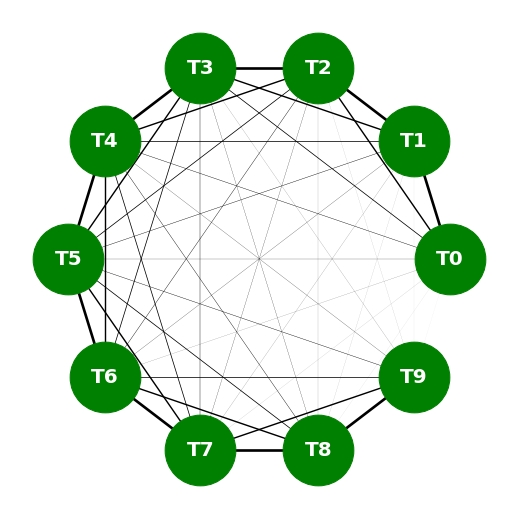

In [7]:
# PLOTTING FUNCITONS
import networkx as nx

cols = [f'T{c}' for c in A_t.columns]
A_t.columns, A_t.index = cols, cols

G = nx.from_pandas_adjacency(A_t, create_using=nx.Graph)
edges = G.edges()
weights = [G[u][v]['weight']**6 *5 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=True, 
                 node_size=5000, node_color='GREEN', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=30)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])

plt.savefig('A_t.png')

# 3. Tensor Data Generation

In [8]:
vids = sorted(set(df_eeg['VideoID']))
sids = sorted(set(df_eeg['SubjectID']))
min_count = df_eeg.groupby(['SubjectID', 'VideoID'])['predefinedlabel'].count().min()

In [9]:
all_samples = []
all_labels = []

# Loop over video and subject id
for vid in vids:   
    
    # Get the DF associated with the video ID
    df_vid = df_eeg[df_eeg['VideoID'] == vid]

    # Generate subjects X samples X time-steps X features data
    vid_samples = []
    vid_labels = []
    for sid in sids:
        df_vidsid = df_vid[df_vid['SubjectID'] == sid]
        samples = np.array([df_vidsid[features].values[i-lbw:i] for i in range(lbw, min_count)])
        labels = np.array([df_vidsid['user-definedlabeln'].mean() for i in range(samples.shape[0])])
        vid_samples.append(samples)
        vid_labels.append(labels)
    vid_samples = np.array(vid_samples)
    vid_labels = np.array(vid_labels)
    
    # Reshape into the right dimensions
    vid_samples = vid_samples.transpose(1, 2, 0, 3)
    vid_labels = vid_labels.transpose(1, 0)
    
    # Concatenate 
    all_samples.append(vid_samples)
    all_labels.append(vid_labels)
    
# Generate final tensor data
X = np.concatenate(all_samples)
Y = np.concatenate(all_labels)
print(X.shape, Y.shape)

(1020, 10, 9, 11) (1020, 9)


In [10]:
# Train-test split
split_idx = int(0.7*X.shape[0])
X_tr, Y_tr = X[:split_idx], Y[:split_idx]
X_te, Y_te = X[split_idx:], Y[split_idx:]

# 4. Modelling

## 4.1. MGTN Model

In [11]:
import tensorflow as tf
from GraphTensorNetworks import SpecialMultiGraphTensorNetwork as SMGTN
from GraphTensorNetworks import TensorTrainLayer as TTL

tf.random.set_seed(0)

In [12]:
graph_list = [A_t.values, A_s.values]
tt_ips = [X.shape[1], X.shape[2], 8]
tt_ops = [3,3,3]
tt_ranks = [1,2,2,1]

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(SMGTN(tt_ips[-1], graph_list, bias_bool=False))
model.add(tf.keras.layers.Activation('tanh'))

# model.add(SMGTN(tt_ips[-1], graph_list, bias_bool=False))
# model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL(tt_ips, tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
special_multi_graph_tensor_n (None, 10, 9, 8)          90        
_________________________________________________________________
activation (Activation)      (None, 10, 9, 8)          0         
_________________________________________________________________
tensor_train_layer (TensorTr (None, 3, 3, 3)           243       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 27)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 252       
Total params: 585
Trainable params: 585
Non-trainable params: 0
__________________________________________________________

In [14]:
model.fit(X_tr, Y_tr, validation_split=0.2, epochs=100, shuffle=False, verbose=False)

In [15]:
preds = model.predict(X_tr)
accuracy_score(np.sign(preds).reshape(-1), Y_tr.reshape(-1))

0.9299719887955182

In [16]:
preds = model.predict(X_te)
accuracy_score(np.sign(preds).reshape(-1), Y_te.reshape(-1))

0.5366739288307916

## 4.2. TTNN Model

In [17]:
X_tr.shape

(714, 10, 9, 11)

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(TTL([10, 9, 11], [2, 2, 2], tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))

# model.add(TTL([10, 9, 8], [10, 9, 8], tt_ranks))
# model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL([2,2,2], tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor_train_layer_1 (Tensor (None, 2, 2, 2)           164       
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
tensor_train_layer_2 (Tensor (None, 3, 3, 3)           75        
_________________________________________________________________
activation_3 (Activation)    (None, 3, 3, 3)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 252       
Total params: 491
Trainable params: 491
Non-trainable params: 0
________________________________________________________

In [19]:
model.fit(X_tr, Y_tr, validation_split=0.2, epochs=100, shuffle=False, verbose=False)

In [20]:
preds = model.predict(X_tr)
accuracy_score(np.sign(preds).reshape(-1), Y_tr.reshape(-1))

0.9159663865546218

In [21]:
preds = model.predict(X_te)
accuracy_score(np.sign(preds).reshape(-1), Y_te.reshape(-1))

0.4974582425562818

## 4.3. GRU Model

In [22]:
X_tr_gru = X_tr.reshape(X_tr.shape[0], lbw, -1)
X_te_gru = X_te.reshape(X_te.shape[0], lbw, -1)

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(lbw, 9*11)))

model.add(tf.keras.layers.GRU(8, return_sequences=True))
model.add(tf.keras.layers.Activation('tanh'))

# model.add(tf.keras.layers.GRU(8, return_sequences=True))
# model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(3**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10, 8)             2616      
_________________________________________________________________
activation_4 (Activation)    (None, 10, 8)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                2187      
_________________________________________________________________
activation_5 (Activation)    (None, 27)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 252       
Total params: 5,055
Trainable params: 5,055
Non-trainable params: 0
____________________________________________________

In [24]:
model.fit(X_tr_gru, Y_tr, validation_split=0.2, epochs=100, shuffle=False, verbose=False)

In [25]:
preds = model.predict(X_tr_gru)
accuracy_score(np.sign(preds).reshape(-1), Y_tr.reshape(-1))

0.9372860255213197

In [26]:
preds = model.predict(X_te_gru)
accuracy_score(np.sign(preds).reshape(-1), Y_te.reshape(-1))

0.5098039215686274

## 4.4. GCN Model

In [27]:
X_tr_gcn = X_tr.transpose(0, 2, 1, 3).reshape(X_tr.shape[0], A_s.shape[0], -1)
X_te_gcn = X_te.transpose(0, 2, 1, 3).reshape(X_te.shape[0], A_s.shape[0], -1)

In [28]:
from GraphTensorNetworks import GraphCNN

In [29]:
g_filter = tf.keras.backend.constant(A_s.values + np.eye(A_s.shape[0]))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(A_s.shape[0], X_tr_gcn.shape[-1])))

model.add(GraphCNN(output_dim=8, num_filters=1, graph_conv_filters=g_filter, input_shape=X_tr_gcn.shape[1:]))
model.add(tf.keras.layers.Activation('tanh'))

# model.add(GraphCNN(output_dim=8, num_filters=1, graph_conv_filters=g_filter, input_shape=X_tr_gcn.shape[1:]))
# model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(3**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_cnn (GraphCNN)         (None, 9, 8)              880       
_________________________________________________________________
activation_6 (Activation)    (None, 9, 8)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1971      
_________________________________________________________________
activation_7 (Activation)    (None, 27)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 252       
Total params: 3,103
Trainable params: 3,103
Non-trainable params: 0
____________________________________________________

In [30]:
model.fit(X_tr_gcn, Y_tr, validation_split=0.2, epochs=100, shuffle=False, verbose=False)

In [31]:
preds = model.predict(X_tr_gcn)
accuracy_score(np.sign(preds).reshape(-1), Y_tr.reshape(-1))

0.9514472455648926

In [32]:
preds = model.predict(X_te_gcn)
accuracy_score(np.sign(preds).reshape(-1), Y_te.reshape(-1))

0.4684095860566449